## Классификация изображений художников разного стиля с использованием `PyTorch`

### Первая часть задания: создание архитектуры классификации изображений с использованием `PyTorch`

Импорт библиотек, фиксация рандома `torch.manual_seed(1)`, определение на чем будем считать: cpu или gpu.

In [1]:
import torch
torch.manual_seed(1)
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
#import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict # to check distribution by classes
from sklearn.metrics import precision_recall_fscore_support # to calculate F1 score
from sklearn.model_selection import StratifiedShuffleSplit # to split images to train, val, and test
import numpy as np
import pandas as pd
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Определяем трансформацию изображений: отдельно для тренировочного набора с аугментацией данных и отдельно для тестового и валидационного.

In [2]:
# define default transormation

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(30),
    transforms.RandomPerspective(p=0.3),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.5, 3.0)),
    #transforms.GaussianNoise(0.1),

    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize()
    #transforms.Normalize(mean, std)

])

Загрузка изображений, которые хранятся в директории `images`. Загружаем два раза один и тот же набор изображений, потому что оказалось что трансформация с аугментацией данных на тренировочном наборе распространяется и на тестовый набор (например вот [ссылка](https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580)). Поэтому принято решение считать два раза и сразу применить нужную трансформацию.   

In [3]:
# image_dataset = torchvision.datasets.ImageFolder('images', transform=val_transform)
train_dataset_whole = torchvision.datasets.ImageFolder('../images', transform=train_transform)
test_valid_dataset = torchvision.datasets.ImageFolder('../images', transform=val_transform)

# print(len(train_dataset_whole))
# print(train_dataset_whole.transform)
image_classes = train_dataset_whole.classes
# print(image_classes)

Разбиваем изображения на трейновый, валидационный и тестовый набор (70%, 20%, 10%) без стратификации. Оказалось, что это работает хуже чем со стратификацией с учетом размеров классов. Поэтому код без стратификации закомментирован.

In [4]:
# train_size = int(0.7 * len(image_dataset))
# val_size = int(0.2 * len(image_dataset))
# test_size = len(image_dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])
# # realize data augmentation for train set
# train_dataset.dataset.transform = train_transform


In [5]:
# print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_size, val_size, test_size))

# print(train_size)
# print(val_size)
# print(test_size)
# print(train_dataset.dataset)

In [6]:
# загрузка данных соответствующего размера
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Разбиваем изображения на трейновый, валидационный и тестовый набор с учетом размеров классов. Такое разбиение позволяет учитывать несбалансированность классов, которая у нас присутствует. Таким образом, от каждого класса будет использовано 70% в трейновом датасете, 20% в валидационном и 10% в тестовом. Кроме того, задаем `random_state` для воспроизводимости

In [7]:
# from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels for each image
# labels = [image_dataset[i][1] for i in range(len(image_dataset))]
labels = [label for _, label in train_dataset_whole]

# Create the stratified shuffle split object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Split the indices of the images into train and validation-test sets
train_index, test_valid_index = next(split.split(range(len(train_dataset_whole)), labels))
test_valid_dataset = torch.utils.data.Subset(test_valid_dataset, test_valid_index)

# Create a second stratified shuffle split object for the train set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
val_index, test_index = next(split.split(range(len(test_valid_dataset)), [label for _, label in test_valid_dataset]))
test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)


In [8]:
# загрузка данных соответствующего размера
train_dataset = torch.utils.data.Subset(train_dataset_whole, train_index)
# train_dataset.dataset.transform = train_transform
# print(train_dataset.dataset)
batch_size = 32 # определяем размер батча
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
print(test_valid_dataset.dataset.transform) # to verify that applied transformation is correct
print(train_dataset.dataset.transform) # to verify that applied transformation is correct
print(image_classes)
print(len(image_classes))
# print(test_valid_index)
# print(test_dataloader.dataset.indices)
print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_index.size, val_index.size, test_index.size))

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    RandomHorizontalFlip(p=0.3)
    RandomVerticalFlip(p=0.3)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    RandomGrayscale(p=0.2)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomPerspective(p=0.3)
    GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 3.0))
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
['ArtDeco', 'Cubism', 'Impressionism', 'Japonism', 'Naturalism', 'Rococo', 'cartoon', 'photo']
8
Train set size: 995, validation set size: 256, test set size: 171


Сохраняем использовавшиеся индексы для обучения модели и тестирования, чтобы повторно использовать их во второй и третьей части задания.

In [10]:
np.save('../data/train_index_42.npy', train_index)
# np.savetxt("features_best.csv", features_np, delimiter=",")
np.save('../data/test_index_42.npy', test_valid_index)



Проверим результат разбиения по классам

In [11]:
def count_classes(dataloader):
    labels_count = defaultdict(int)
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        for label in labels:
            labels_count[label.item()] += 1
    return(labels_count)

data = {'Train set': count_classes(train_dataloader),
        'Validation set': count_classes(val_dataloader),
        'Test set': count_classes(test_dataloader)}
# print(data)


Отрисуем результат разбиения по классам на тренировочный, валидационный и тестовый набор

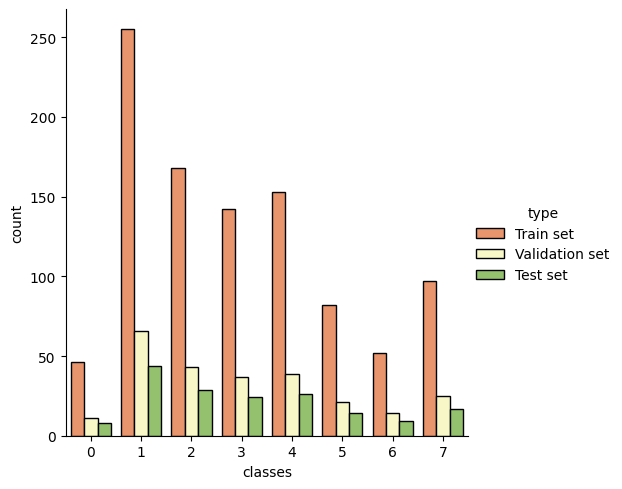

In [12]:
keys = list(data['Train set'].keys())
train_values = list(data['Train set'].values())
val_values = list(data['Validation set'].values())
test_values = list(data['Test set'].values())

df = pd.DataFrame()
for group, items in data.items():
    temp = pd.DataFrame.from_dict(items, orient='index', columns=[group])
    df = pd.concat([df, temp], axis=1, sort=False)

# преобразуем данные в длинный формат для построения графика

df = df.reset_index().melt(id_vars='index', value_vars=list(data.keys()), value_name='count', var_name='type')
df.rename(columns={'index': 'classes'}, inplace=True)

sns.catplot(x="classes", y="count", kind="bar", hue = 'type', 
            data=df, dodge=True, edgecolor = 'black', palette=sns.color_palette(['#fc8d59', '#ffffbf', '#91cf60']))

plt.show()


Определяем функцию для отрисовки изображений с лейблами

In [13]:
def showimages(imgs,actual_lbls,pred_lbls=None):
  
  fig = plt.figure(figsize=(21,12))

  for i,img in enumerate(imgs):
    
    fig.add_subplot(4,8, i+1)
    y=actual_lbls[i]
    
    if pred_lbls!=None:
      y_pre=pred_lbls[i]
      title="prediction: {0}\nlabel:{1}".format(image_classes[y_pre], image_classes[y])
    else: 
      title="Label: {0}".format(image_classes[y])

    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)
  
# plt.show()

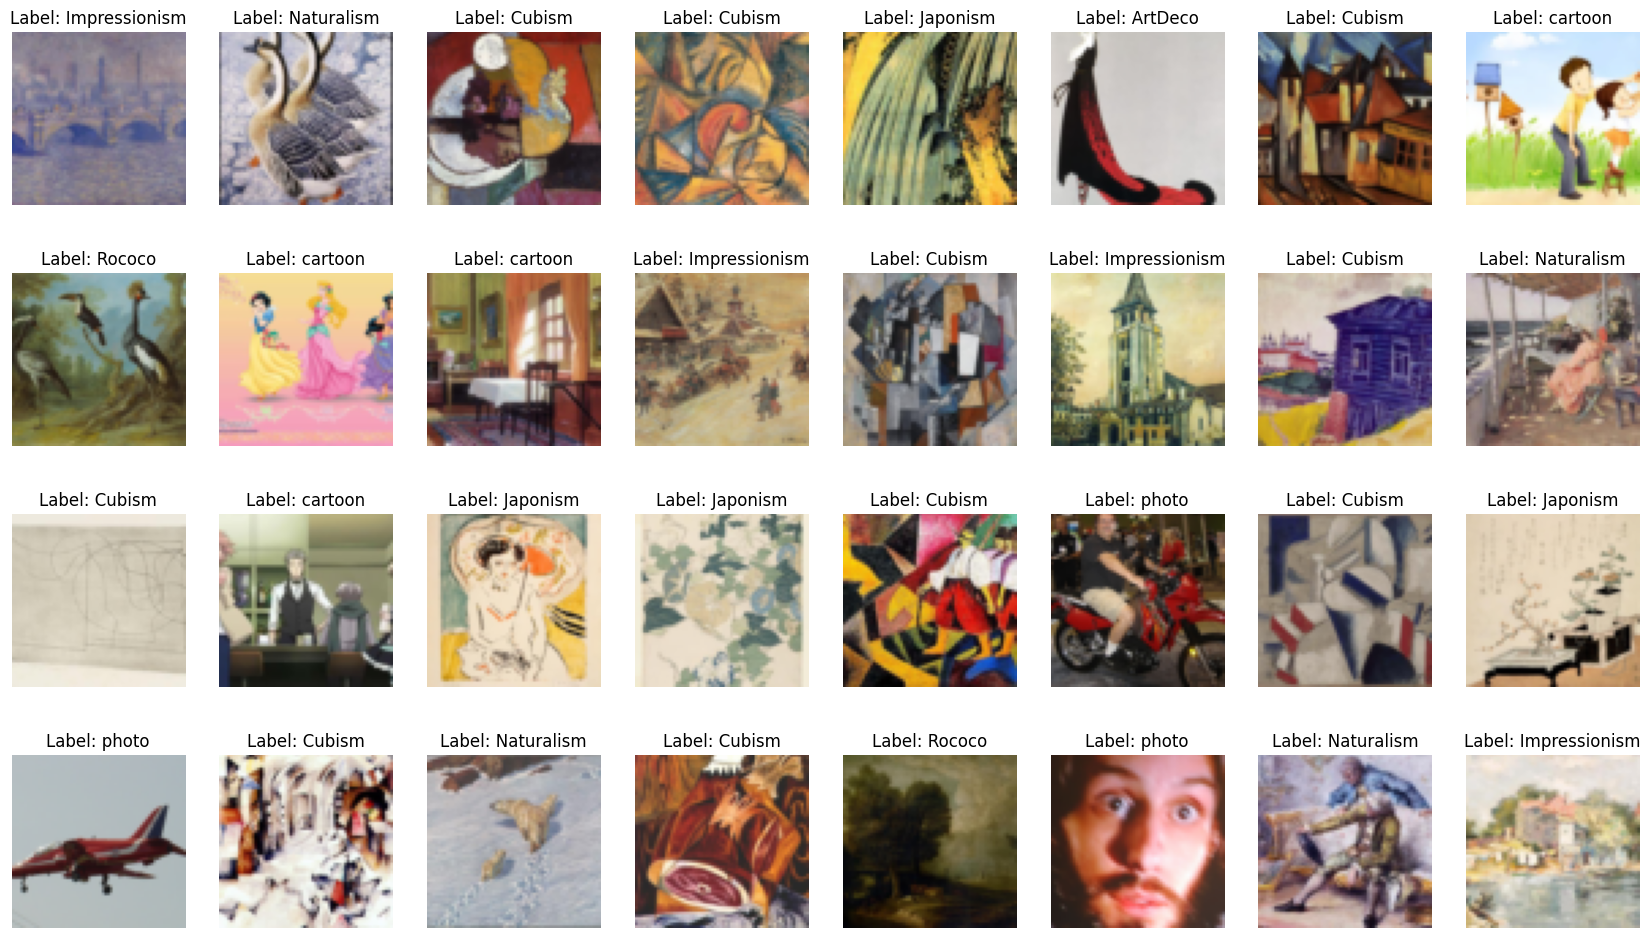

In [14]:
inputs, classes = next(iter(test_dataloader)) # отрисуем тестовые изображения

showimages(inputs, classes) # убедились что аугментация не была применена для теста, как и было задумано

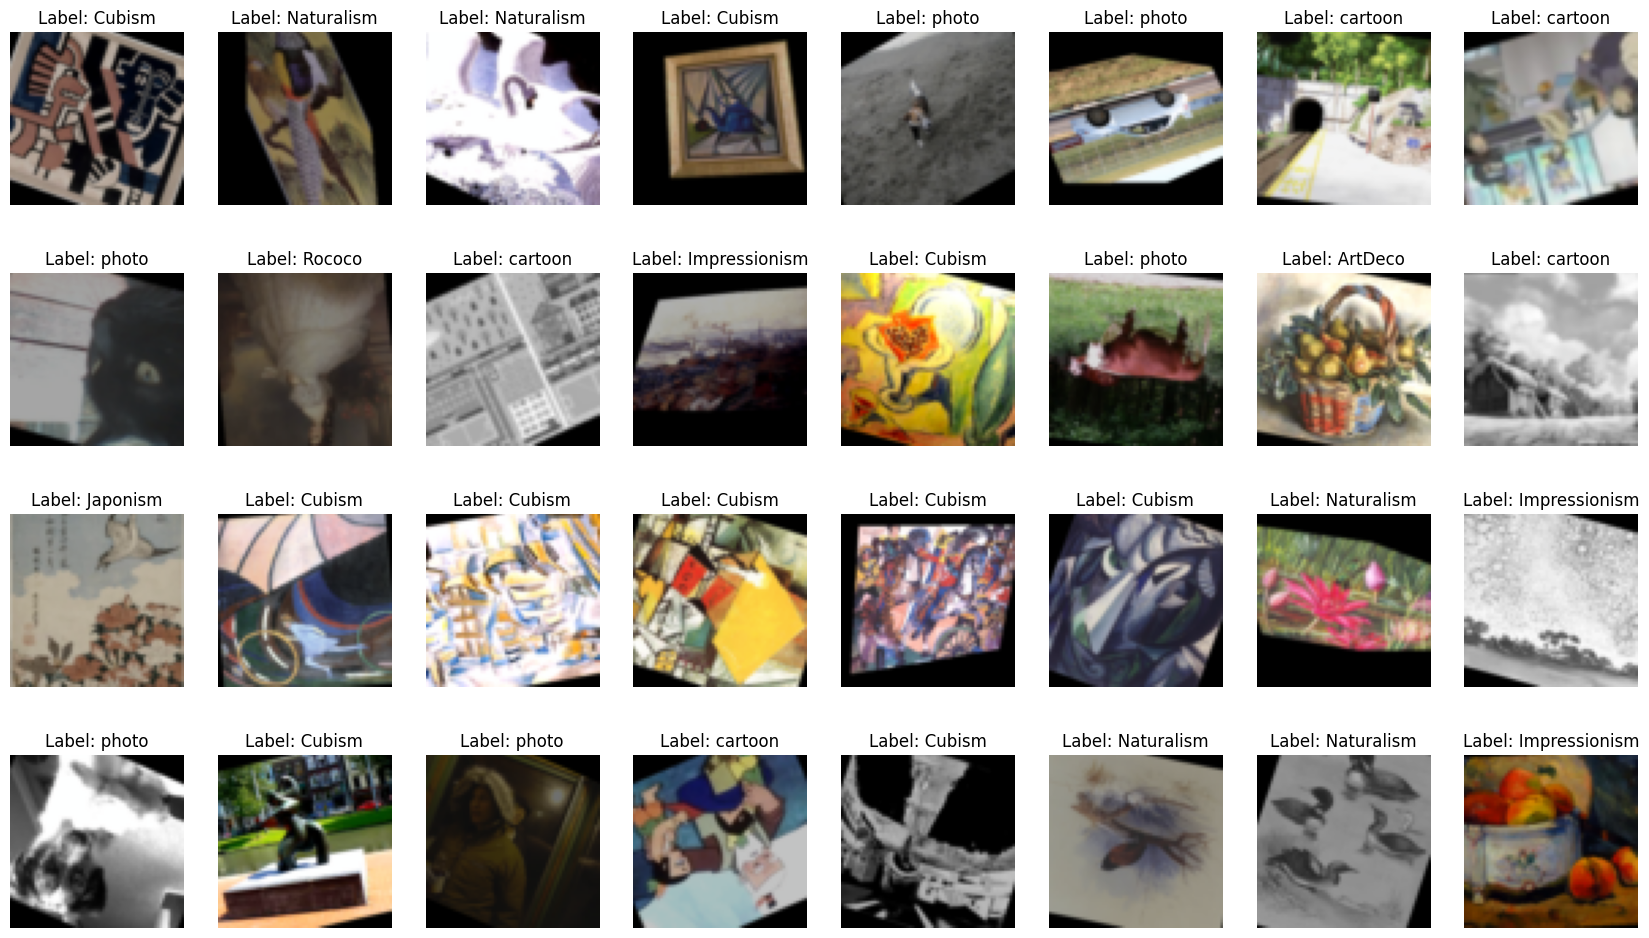

In [15]:
inputs, classes = next(iter(train_dataloader)) # отрисуем трейновые изображения

showimages(inputs, classes) # аугментация удалась

Определяем модель для классификации изображений: resnet с 18 слоями, задаем на полносвязном уровне количество наших классов. Модель с дропаутом показывала хуже результат, а вот L2-регуляризация оказалась полезной. 

In [16]:
model = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
# model = torchvision.models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')

#model = torchvision.models.resnet50(weights=True)

model.fc = nn.Linear(512, len(image_classes))

# dropout

# model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.1, training=m.training))

#model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))


Выбираем функцию ошибки CrossEntropyLoss, поскольку у нас задача классификации нескольких классов. Например, можно почитать об этом [здесь](https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451), [здесь](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 
Использование стохастического градиентного спуска показало самый лучший результат в этой задаче. Еще полезным оказался параметр `weight_decay` для L2-регуляризации.


In [17]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,  weight_decay=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,  weight_decay=0.002)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,  weight_decay=0.01)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters()) # this optimizer functioned really bad

In [18]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
# f1_scores = []

Запускаем обучение нейросети на 30 эпохах (большее число эпох не улучшало показатели). Модель, для которой показан самый лучший (минимальный) лосс на валидационном скоре сохраняем в файл для последущей загрузки.

In [ ]:
num_epochs = 30

best_accuracy = 0
best_loss = float('inf')
best_epoch = 0
# best_f1_score = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate the average loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валидация модели
    with torch.no_grad():
        running_loss_val = 0.0
        total = 0
        correct = 0
#         confusion_matrix = torch.zeros(len(image_classes), len(image_classes), dtype=torch.int64)
        true_labels = []
        pred_labels = []

        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_val = criterion(outputs, labels)
            running_loss_val += loss_val.item()
            _, preds = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            true_labels.extend(labels.tolist())
            pred_labels.extend(preds.tolist())

        val_loss = running_loss_val / len(val_dataloader)
        val_accuracy = 100 * correct / total


    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
#     f1_scores.append(f1_score)

    print("Epoch {}/{} - Train Loss: {:.4f} - Train Accuracy: {:.2f}% - Val Loss: {:.4f} - Val Accuracy: {:.4f}%".format(
        epoch + 1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), '../data/best_model_finally_42_1seed.pt')

Epoch 1/30 - Train Loss: 2.0390 - Train Accuracy: 25.03% - Val Loss: 1.7221 - Val Accuracy: 37.5000%
Epoch 2/30 - Train Loss: 1.6080 - Train Accuracy: 42.51% - Val Loss: 1.5088 - Val Accuracy: 46.0938%
Epoch 3/30 - Train Loss: 1.5180 - Train Accuracy: 46.53% - Val Loss: 1.4401 - Val Accuracy: 46.8750%
Epoch 4/30 - Train Loss: 1.4490 - Train Accuracy: 50.25% - Val Loss: 1.4035 - Val Accuracy: 49.6094%
Epoch 5/30 - Train Loss: 1.2998 - Train Accuracy: 54.77% - Val Loss: 1.3464 - Val Accuracy: 54.2969%
Epoch 6/30 - Train Loss: 1.2940 - Train Accuracy: 54.27% - Val Loss: 1.2974 - Val Accuracy: 53.1250%
Epoch 7/30 - Train Loss: 1.2693 - Train Accuracy: 58.29% - Val Loss: 1.2168 - Val Accuracy: 56.6406%
Epoch 8/30 - Train Loss: 1.1585 - Train Accuracy: 61.11% - Val Loss: 1.2578 - Val Accuracy: 57.0312%
Epoch 9/30 - Train Loss: 1.2193 - Train Accuracy: 58.39% - Val Loss: 1.2091 - Val Accuracy: 58.2031%
Epoch 10/30 - Train Loss: 1.1055 - Train Accuracy: 63.62% - Val Loss: 1.1988 - Val Accuracy

На всякий случай сохраняю последнее состояние модели тоже, если понадобится сравнить. Иногда оказывается, что модель, обученная на полном числе эпох (30) показывает лучшие показатели качества.

In [ ]:
torch.save(model.state_dict(), '../data/best_model_42_1seed_last.pt')

Строим графики изменения функции ошибки и точности на трейновом и валидационном наборе данных 

In [ ]:
epochs = range(1, num_epochs + 1)
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '--')
plt.xticks(rotation=45)

plt.show()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xticks(range(1, num_epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=45)

plt.axvline(x = best_epoch+1, linestyle = '--')
plt.show()

print(best_loss)
print(best_epoch)

#plt.plt(train_losses, val_losses)

Можно увидеть, что точность на тренировочном наборе увеличивается, а лосс уменьшается, но впоследствии точность на валидацонном и лосс не улучшаются, поэтому используем сохраненный лучший стейт модели. Можно сделать вывод, что модель сходится.

In [ ]:
model.load_state_dict(torch.load('../data/best_model_finally_42_1seed.pt'))


Тестируем качество нашей модели на тестовой выборке. Вычисляем точность и F1-score (выбран взвешенный, чтобы каждый класс изображений имел равный вклад).

In [ ]:
# Initialize the confusion matrix

confusion_matrix = torch.zeros(len(image_classes), len(image_classes), dtype=torch.int64)

true_labels = []
pred_labels = []

# Evaluation mode
model.eval()

# Set the gradient computation to be off
with torch.no_grad():
    running_loss = 0.0
    total = 0
    correct = 0
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        true_labels.extend(labels.tolist())
        pred_labels.extend(preds.tolist())
        # 
        for t, p in zip(labels, preds):
            confusion_matrix[t, p] += 1
    test_loss = running_loss / len(test_dataloader)
    test_accuracy = 100 * correct / total

# Вычислим чувствительность, специфичность и f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print("Test loss: {:.4f}, test Accuracy: {:.2f}%, weighted test F1-Score: {:.4f}".format(test_loss, test_accuracy, f1_score))
print('Precision: {:.4f}, recall: {:.4f}'.format(precision, recall))

63% Точности и 62.5% f1 score это не супер хорошие результаты, однако на этих данных с тюнингом гиперпараметров не удавалось получать результаты значительно лучше. Один раз удалось достигнуть точности 85%, однако это делалось без фиксации сидов, в результате не получилось воспроизвести :(

In [ ]:
# print(confusion_matrix)
# для красивого отображения confusion matrix:
dataframe = pd.DataFrame(confusion_matrix, index=image_classes, columns=image_classes)
# print(dataframe)
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

Посмотрим на часть тестовых изображений с предсказанными и истинными лейблами

In [ ]:
def predict_images(model,images,actual_label):
  model.eval()
  with torch.no_grad():
    inputs = images.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    showimages(images, actual_label, preds.cpu())
    

images, classes = next(iter(test_dataloader))

predict_images(model,images,classes)

Если нужно проверить другой стейт модели:

In [ ]:
# model.load_state_dict(torch.load('../data/best_model_42_1seed_last.pt'))
